# Classifying Outdoor Images from Google Images


In [5]:
from fastai.vision import *

## Get A List of URLs

On Google Images, Open Console and Paste the following JavaScript:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

The goal is to classify outdoor images into 4 Categories: Cities, Beaches, Mountains, and Forests. 

### Create A Directory & Upload Files Into The Server



In [6]:
folder = 'cities'
file = 'urls_cities.csv'

In [10]:
folder = 'forests'
file = 'urls_forests.csv'

In [14]:
folder = 'mountains'
file = 'urls_mountains.csv'

In [18]:
folder = 'beaches'
file = 'urls_beaches.csv'

Create the Directories: You will need to run this cell once per each category.

In [19]:
path = Path('data/outdoor')
dest = path/folder
dest.mkdir(parents = True, exist_ok = True)

In [15]:
path.ls()

[PosixPath('data/outdoor/forests'),
 PosixPath('data/outdoor/urls_cities.csv'),
 PosixPath('data/outdoor/urls_mountains.csv'),
 PosixPath('data/outdoor/urls_beaches.csv'),
 PosixPath('data/outdoor/urls_forests.csv'),
 PosixPath('data/outdoor/cities'),
 PosixPath('data/outdoor/mountains'),
 PosixPath('data/outdoor/beaches')]

## Download Images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [20]:
classes = ['beaches', 'cities', 'forests', 'mountains']


In [21]:
download_images(path/file, dest, max_pics=200)

Then we can remove any images that can't be opened:

In [22]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View Images

In [23]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [24]:
data.classes

['beaches', 'cities', 'forests', 'mountains']

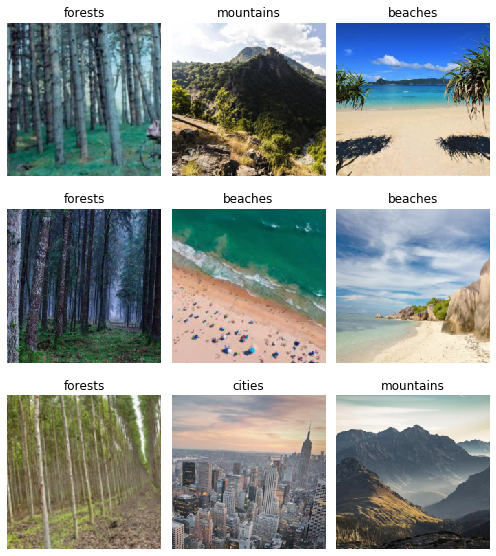

In [26]:
data.show_batch(rows=3, figsize=(7,8))

In [27]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['beaches', 'cities', 'forests', 'mountains'], 4, 308, 76)

## Train Model

In [28]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.225021,0.698682,0.184211,00:06
1,0.683585,0.043418,0.013158,00:03
2,0.472463,0.016844,0.000000,00:03
3,0.353178,0.012251,0.000000,00:03


In [30]:
learn.save('stage-1')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


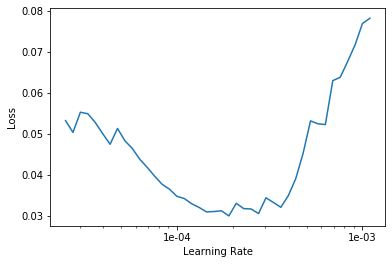

In [33]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.032897,0.038140,0.013158,00:03
1,0.026519,0.143293,0.013158,00:03
2,0.018331,0.155844,0.013158,00:03
3,0.014713,0.149878,0.013158,00:03


In [40]:
learn.save('stage-2');

## Interpretation

In [41]:
learn.load('stage-2');

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

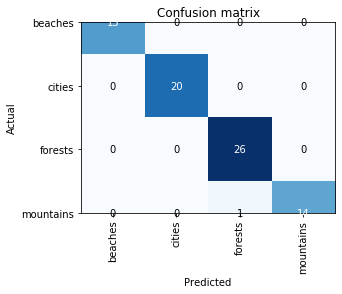

In [43]:
interp.plot_confusion_matrix()

## Cleaning Up
Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.
Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [44]:
from fastai.widgets import *

In order to clean the entire set of images, we need to create a new dataset without the split.

In [45]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [47]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-2');

In [48]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [49]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Recreate the databunch and learn_cln from the cleaned.csv file

## Putting Model To Production

First thing first, let's export the content of our `Learner` object for production:

In [50]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [51]:
defaults.device = torch.device('cpu')

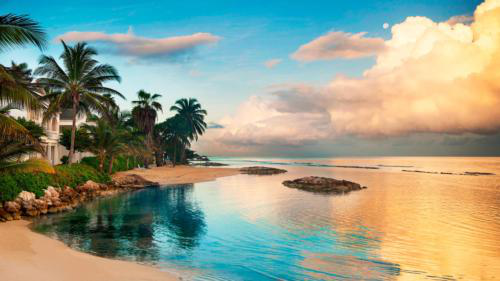

In [52]:
img = open_image(path/'beaches'/'00000012.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [54]:
learn = load_learner(path)

In [55]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category beaches

## Things That Could Go Wrong

### Learning Rate Too High

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [57]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,19.320267,18344801468416.000000,0.802632,00:03


### Learning Rate Too Low

In [58]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [59]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.189448,1.725933,0.657895,00:03
1,2.024454,1.478788,0.631579,00:03
2,2.042115,1.362595,0.684211,00:03
3,1.996765,1.316654,0.644737,00:03
4,2.014741,1.307619,0.592105,00:03


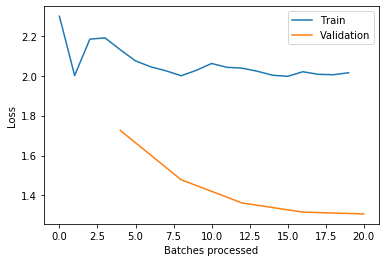

In [60]:
learn.recorder.plot_losses()

### Too Few Epochs

In [61]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, pretrained=False)

In [62]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.293861,1.525270,0.657895,00:03


### Too Many Epochs

In [63]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [64]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [65]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.915774,1.774761,0.759420,00:04
1,1.925852,1.723358,0.744928,00:02
2,1.883329,1.667158,0.730435,00:02
3,1.782087,1.606580,0.689855,00:02
4,1.690710,1.509052,0.640580,00:02
5,1.617300,1.403084,0.585507,00:02
6,1.501286,1.290790,0.518841,00:02
7,1.379687,1.167782,0.457971,00:02
8,1.283530,1.043898,0.382609,00:02
9,1.188078,0.934706,0.344928,00:02
